In [1]:
import os
import sys
import pandas as pd
import json
import yaml
import time
from ananke.graphs import ADMG
from networkx import DiGraph
from optparse import OptionParser
from sklearn.preprocessing import MinMaxScaler
from causal_model import CausalModel
from pyCausalFS.GSL.MMHC.MMHC import *

C:\Users\28210\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
NUM_PATHS = 25
query = "best"

def get_metrics_from_txt(txt):
    with open(txt, 'r') as file:
        lines = [line.strip() for line in file.readlines()]
    result = []
    for line in lines:
        if len(line.split('{')) != 1:
            line = line.split('{')[0] + ' ' + line.split(' ')[1]
        result.append(line)

    return result
def get_metrics_name_from_txt(txt):
    metrics_name = []
    metrics_selected = get_metrics_from_txt(txt)
    for name in metrics_selected:
        metrics_name.append(name.split(' ')[0])
    return metrics_name, len(metrics_name)

metrics_selected_columns,_ = get_metrics_name_from_txt('redis/redis_metrics_1.txt')

metrics_selected_columns

['redis_active_defrag_running',
 'redis_allocator_frag_bytes',
 'redis_allocator_frag_ratio',
 'redis_allocator_rss_ratio',
 'redis_aof_base_size_bytes',
 'redis_aof_buffer_length',
 'redis_aof_current_rewrite_duration_sec',
 'redis_aof_delayed_fsync',
 'redis_aof_enabled',
 'redis_aof_last_bgrewrite_status',
 'redis_aof_last_cow_size_bytes',
 'redis_aof_last_rewrite_duration_sec',
 'redis_aof_last_write_status',
 'redis_aof_pending_bio_fsync',
 'redis_aof_pending_rewrite',
 'redis_aof_rewrite_in_progress',
 'redis_aof_rewrite_scheduled',
 'redis_blocked_clients',
 'redis_client_recent_max_input_buffer_bytes',
 'redis_client_recent_max_output_buffer_bytes',
 'redis_clients_in_timeout_table',
 'redis_cluster_connections',
 'redis_cluster_enabled',
 'redis_config_io_threads',
 'redis_config_maxclients',
 'redis_connected_clients',
 'redis_connected_slaves',
 'redis_connections_received_total',
 'redis_cpu_sys_children_seconds_total',
 'redis_cpu_sys_main_thread_seconds_total',
 'redis_cp

In [3]:

def get_conf_name_form_csv(csv):
    parameters = pd.read_csv(csv)
    conf_opt = (parameters['microservice'] + '_' + parameters['parameter']).tolist()
    conf_opt = [conf.replace('-', '_') for conf in conf_opt]
    return conf_opt
conf_opt = get_conf_name_form_csv('redis/redis_both_all.csv')


In [4]:

obj_columns = ['insert']
columns = metrics_selected_columns + conf_opt + obj_columns

df = pd.read_csv('redis/redis_insert_3.csv')

df

,task_id,read,update,scan,insert,redis_redis_tcp_keepalive,redis_repl_diskless_sync_delay,redis_maxmemory,redis_maxmemory_policy,redis_maxmemory_samples,...,redis_total_error_replies,redis_total_reads_processed,redis_total_writes_processed,redis_tracking_clients,redis_tracking_total_items,redis_tracking_total_keys,redis_tracking_total_prefixes,redis_unexpected_error_replies,redis_up,redis_uptime_in_seconds
0,1,94.0,71.0,79039.0,157.0,160,4,4446,volatile-ttl,12,...,0.0,271897.00,271891.00,0.0,0.0,0.0,0.0,0.0,1.0,85.33
1,2,95.0,74.0,76991.0,157.0,101,6,752,allkeys-random,4,...,0.0,266718.00,266714.00,0.0,0.0,0.0,0.0,0.0,1.0,86.00
2,3,95.0,70.0,73407.0,157.0,278,9,3021,volatile-ttl,19,...,0.0,263450.00,263446.00,0.0,0.0,0.0,0.0,0.0,1.0,129.00
3,4,101.0,67.0,73727.0,154.0,375,7,4018,allkeys-random,11,...,0.0,257944.00,257940.00,0.0,0.0,0.0,0.0,0.0,1.0,108.00
4,5,95.0,77.0,75967.0,158.0,311,2,728,allkeys-lfu,15,...,0.0,276260.00,276256.00,0.0,0.0,0.0,0.0,0.0,1.0,114.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,367,90.0,74.0,82687.0,160.0,360,7,3989,volatile-ttl,12,...,0.0,276254.33,276248.67,0.0,0.0,0.0,0.0,0.0,1.0,87.00
366,368,94.0,80.0,78335.0,162.0,372,7,4565,volatile-lru,13,...,0.0,269709.67,269703.33,0.0,0.0,0.0,0.0,0.0,1.0,103.00
367,369,93.0,76.0,72447.0,157.0,488,6,3175,noeviction,8,...,0.0,261472.33,261467.67,0.0,0.0,0.0,0.0,0.0,1.0,86.00
368,370,96.0,76.0,84159.0,165.0,396,7,3809,allkeys-lru,5,...,0.0,274749.00,274741.00,0.0,0.0,0.0,0.0,0.0,1.0,102.00


In [5]:
def process_data(df,software,columns):
    df = df[columns]
    df = df.dropna()
    parameters_str_conf = {
        'mongodb': {
            'mongodb_journalCompressor' : ['none','snappy','zlib','zstd'],
            'mongodb_blockCompressor' : ['none','snappy','zlib','zstd'],
            'mongodb_netCompressors' : ['snappy','zlib','zstd'],
            'mongodb_serviceExecutor' : ['synchronous','adaptive']
        },
        'redis': {
            'redis_maxmemory_policy': ['volatile-lru','allkeys-lru','volatile-lfu','allkeys-lfu','volatile-random','allkeys-random','volatile-ttl','noeviction']
        },
        'nginx': {
            'nginx_sendfile': ['off','on'],
            'nginx_tcp_nopush': ['off','on'],
            'nginx_tcp_nodelay': ['off','on'],
        },
        'mysql': {
            'mysql_transaction_isolation': ['READ-UNCOMMITTED','READ-COMMITTED','REPEATABLE-READ','SERIALIZABLE']
        }
    }
    if software in parameters_str_conf.keys():
        for k ,v in parameters_str_conf[software].items():
            df[k] = df[k].map(lambda x: float(v.index(x))+1 if x in v else -1)
    columns_nunique = df.columns[df.nunique() == 1].tolist()
    columns_equal = []
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                if df[col1].equals(df[col2]):
                    columns_equal.append(col2)

    bad_col = []
    bad_col = ['mongodb_ss_wt_cache_eviction_calls_to_get_a_page','mongodb_ss_wt_log_log_server_thread_advances_write_LSN','mongodb_ss_wt_cache_pages_queued_for_eviction_post_lru_sorting','mongodb_ss_wt_checkpoint_cleanup_pages_visited','mongodb_ss_wt_cache_pages_read_into_cache_after_truncate']
    bad_col += ['memcached_lru_crawler_starts_total','memcached_slab_current_pages','memcached_connections_total','memcached_items_evicted_total','memcached_slab_current_pages','memcached_slab_current_pages','memcached_slab_hot_age_seconds','memcached_slab_hot_items','memcached_slab_items_evicted_time_seconds','memcached_slab_hot_items','memcached_slab_current_pages','memcached_slab_items_evicted_unfetched_total','memcached_lru_crawler_starts_total']
    bad_col += ['nginx_threads', 'nginx_max_queue']
    bad_col += ['mysql_global_status_innodb_buffer_pool_read_requests','mysql_global_status_innodb_buffer_pool_write_requests','mysql_global_status_innodb_data_reads','mysql_global_status_binlog_cache_use','mysql_global_status_connections','mysql_global_status_innodb_data_fsyncs','mysql_global_status_innodb_log_writes','mysql_global_status_innodb_os_log_fsyncs','mysql_global_status_innodb_pages_read']
    bad_col += ['redis_cpu_sys_children_seconds_total','redis_last_slow_execution_duration_seconds','redis_aof_delayed_fsync','redis_allocator_rss_ratio','redis_client_recent_max_input_buffer_bytes','redis_client_recent_max_output_buffer_bytes','redis_exporter_last_scrape_duration_seconds','redis_slowlog_length','redis_keyspace_misses_total','redis_latest_fork_seconds','redis_mem_clients_normal','redis_slowlog_last_id','redis_aof_buffer_length','redis_aof_current_rewrite_duration_sec','redis_aof_pending_bio_fsync','redis_aof_rewrite_in_progress','redis_aof_rewrite_in_progress','redis_connected_clients']
    columns_not = []
    columns_not = columns_nunique + columns_equal + bad_col

    columns  = [item for item in columns if item not in columns_not]
    df = df[columns]
    corr_matrix = df.corr()

    threshold = 1

    rows_to_drop = []
    columns_to_drop = []
    for i in range(len(corr_matrix.index)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                row_to_drop = corr_matrix.index[i]
                column_to_drop = corr_matrix.columns[j]
                if row_to_drop not in rows_to_drop:
                    rows_to_drop.append(row_to_drop)
                if column_to_drop not in columns_to_drop:
                    columns_to_drop.append(column_to_drop)

    print(columns_to_drop)
    columns  = [item for item in columns if item not in columns_to_drop]
    df = df.astype(float)
    df = df.reset_index(drop=True)
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df,columns

In [6]:
df,columns=process_data(df,'redis',columns)
df,columns=process_data(df,'redis',columns)

df

['redis_maxclients']
[]


,redis_allocator_frag_bytes,redis_aof_base_size_bytes,redis_aof_last_cow_size_bytes,redis_aof_last_rewrite_duration_sec,redis_config_maxclients,redis_connections_received_total,redis_cpu_sys_main_thread_seconds_total,redis_cpu_sys_seconds_total,redis_cpu_user_children_seconds_total,redis_cpu_user_main_thread_seconds_total,...,redis_list_compress_depth,redis_set_max_intset_entries,redis_zset_max_ziplist_entries,redis_zset_max_ziplist_value,redis_hll_sparse_max_bytes,redis_hz,redis_active_defrag_ignore_bytes,redis_lua_time_limit,redis_resource,insert
0,0.573053,0.011804,0.731257,0.000000,0.974629,0.214362,0.567308,0.572816,0.444444,0.470588,...,0.000000,0.507833,0.095506,0.023037,0.793057,0.855556,0.377778,0.596132,0.482759,0.013699
1,0.280071,0.018550,0.919262,0.111111,0.596508,0.000000,0.509615,0.504854,0.427984,0.573529,...,0.666667,0.997389,0.097753,0.242932,0.171785,0.855556,0.415556,0.397755,0.344828,0.013699
2,0.298343,0.013491,0.738178,0.000000,0.020095,0.000000,0.413462,0.417476,0.432099,0.779412,...,0.666667,0.220627,0.023596,0.918325,0.941144,0.466667,0.700000,0.148477,0.275862,0.013699
3,0.359359,0.015177,0.738178,0.000000,0.998199,0.000000,0.288462,0.281553,0.502058,0.602941,...,0.666667,0.826371,0.837079,0.432461,0.059190,0.277778,0.442222,0.530785,0.379310,0.003425
4,0.279651,0.015177,0.735871,0.000000,0.586144,0.000000,0.480769,0.475728,0.378601,0.529412,...,0.333333,0.439948,0.064045,0.058639,0.284045,0.000000,0.420000,0.088131,0.448276,0.017123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,0.636936,0.013491,0.723183,0.000000,0.316890,0.178992,0.490385,0.475728,0.403292,0.691176,...,1.000000,0.361619,0.506742,0.923560,0.547508,0.288889,0.275556,0.982552,0.241379,0.023973
366,0.624956,0.015177,0.836217,0.000000,0.711262,0.249732,0.538462,0.524272,0.234568,0.720588,...,1.000000,0.522193,0.301124,0.668063,0.906987,0.244444,0.397778,0.699822,0.724138,0.030822
367,0.236348,0.013491,0.949250,0.111111,0.941738,0.071811,0.355769,0.359223,0.390947,0.441176,...,0.333333,0.859008,0.791011,0.486911,0.090231,0.266667,0.160000,0.655924,0.344828,0.013699
368,0.385974,0.008432,0.739331,0.000000,0.646776,0.428725,0.538462,0.524272,0.234568,0.514706,...,1.000000,0.823760,0.830337,0.862827,0.477526,0.011111,0.462222,0.399867,0.206897,0.041096


In [7]:
index = columns.index('redis_redis_tcp_keepalive')
index


23

In [8]:
colmap = {}
for i in range(len(columns)):
    colmap[i] = columns[i]
len(colmap)

41

In [9]:
metrics_selected_columns = columns[:index]
conf_opt = columns[index:-1]
obj_columns = [columns[-1]]

In [10]:
conf_opt

['redis_redis_tcp_keepalive',
 'redis_repl_diskless_sync_delay',
 'redis_maxmemory',
 'redis_maxmemory_samples',
 'redis_tcp_backlog',
 'redis_list_max_ziplist_size',
 'redis_hash_max_ziplist_entries',
 'redis_hash_max_ziplist_value',
 'redis_list_compress_depth',
 'redis_set_max_intset_entries',
 'redis_zset_max_ziplist_entries',
 'redis_zset_max_ziplist_value',
 'redis_hll_sparse_max_bytes',
 'redis_hz',
 'redis_active_defrag_ignore_bytes',
 'redis_lua_time_limit',
 'redis_resource']

In [11]:
df_numpy = df.to_numpy()
CM = CausalModel(columns)
tabu_edges = CM.get_tabu_edges(columns, conf_opt, obj_columns)
tabu_edges

initializing CausalModel class


[('redis_allocator_frag_bytes', 'redis_redis_tcp_keepalive'),
 ('redis_aof_base_size_bytes', 'redis_redis_tcp_keepalive'),
 ('redis_aof_last_cow_size_bytes', 'redis_redis_tcp_keepalive'),
 ('redis_aof_last_rewrite_duration_sec', 'redis_redis_tcp_keepalive'),
 ('redis_config_maxclients', 'redis_redis_tcp_keepalive'),
 ('redis_connections_received_total', 'redis_redis_tcp_keepalive'),
 ('redis_cpu_sys_main_thread_seconds_total', 'redis_redis_tcp_keepalive'),
 ('redis_cpu_sys_seconds_total', 'redis_redis_tcp_keepalive'),
 ('redis_cpu_user_children_seconds_total', 'redis_redis_tcp_keepalive'),
 ('redis_cpu_user_main_thread_seconds_total', 'redis_redis_tcp_keepalive'),
 ('redis_cpu_user_seconds_total', 'redis_redis_tcp_keepalive'),
 ('redis_keyspace_hits_total', 'redis_redis_tcp_keepalive'),
 ('redis_mem_fragmentation_ratio', 'redis_redis_tcp_keepalive'),
 ('redis_mem_not_counted_for_eviction_bytes', 'redis_redis_tcp_keepalive'),
 ('redis_memory_used_overhead_bytes', 'redis_redis_tcp_keepal

In [12]:
c_indx = df['redis_resource']
c_indx = c_indx.to_numpy().reshape(370,1)
c_indx.shape

(370, 1)

In [13]:

new_df = df.drop('redis_resource', axis=1)


In [14]:
from my_cdnod import my_cdnod
cg = my_cdnod(new_df.to_numpy(),c_indx,alpha=0.2)
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
nodes = cg.G.get_nodes()
bk = BackgroundKnowledge()
for ce in tabu_edges:
    f = list(colmap.keys())[list(colmap.values()).index(ce[0])]
    s = list(colmap.keys())[list(colmap.values()).index(ce[1])]
    bk.add_forbidden_by_node(nodes[f], nodes[s])
cg = my_cdnod(new_df.to_numpy(),c_indx,alpha=0.2,background_knowledge=bk)
edges = cg.G.get_graph_edges()
cdnod_edges = []
for edge in edges:
    cdnod_edges.append(str(edge))
cdnod_edges

  0%|          | 0/41 [00:00<?, ?it/s]

40


  0%|          | 0/41 [00:00<?, ?it/s]

40


['X6 --> X1',
 'X14 --> X1',
 'X35 --> X1',
 'X40 --> X1',
 'X3 --> X2',
 'X4 --> X2',
 'X9 --> X2',
 'X40 --> X2',
 'X20 --> X3',
 'X26 --> X3',
 'X19 --> X4',
 'X40 --> X4',
 'X41 --> X4',
 'X5 --> X13',
 'X15 --> X5',
 'X16 --> X5',
 'X27 --> X5',
 'X37 --> X5',
 'X9 --> X6',
 'X15 --> X6',
 'X23 --> X6',
 'X36 --> X6',
 'X7 --- X8',
 'X18 --> X9',
 'X20 --> X9',
 'X23 --> X9',
 'X35 --> X9',
 'X41 --> X9',
 'X10 --- X11',
 'X10 --- X12',
 'X11 --- X12',
 'X15 --> X13',
 'X40 --> X13',
 'X41 --> X14',
 'X24 --> X15',
 'X26 --> X15',
 'X31 --> X15',
 'X36 --> X16',
 'X41 --> X16',
 'X19 --> X17',
 'X20 --> X17',
 'X23 --> X17',
 'X27 --> X17',
 'X23 --> X18',
 'X32 --> X18',
 'X36 --> X18',
 'X40 --> X18',
 'X25 --> X19',
 'X37 --> X20',
 'X40 --> X20',
 'X41 --> X20',
 'X21 --- X22',
 'X39 --> X23',
 'X24 --> X31',
 'X24 --> X32',
 'X24 --> X34',
 'X24 --> X35',
 'X24 --> X39',
 'X25 --> X26',
 'X25 --> X28',
 'X25 --> X29',
 'X25 --> X30',
 'X25 --> X31',
 'X26 --> X28',
 'X26 --> 

In [15]:
from causallearn.search.ConstraintBased.CDNOD import cdnod
from my_cdnod import my_cdnod
cg = my_cdnod(new_df.to_numpy(),c_indx,alpha=0.2)


  0%|          | 0/41 [00:00<?, ?it/s]

40


In [18]:

from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
nodes = cg.G.get_nodes()
bk = BackgroundKnowledge()
for ce in tabu_edges:
    f = list(colmap.keys())[list(colmap.values()).index(ce[0])]
    s = list(colmap.keys())[list(colmap.values()).index(ce[1])]
    bk.add_forbidden_by_node(nodes[f], nodes[s])
cg = my_cdnod(new_df.to_numpy(),c_indx,alpha=0.2,background_knowledge=bk)
edges = cg.G.get_graph_edges()
cdnod_edges = []
for edge in edges:
    cdnod_edges.append(str(edge))
cdnod_edges

  0%|          | 0/53 [00:00<?, ?it/s]

52


['X13 --> X1',
 'X25 --> X1',
 'X47 --> X1',
 'X11 --> X2',
 'X46 --> X2',
 'X49 --> X2',
 'X17 --> X3',
 'X23 --> X3',
 'X4 --- X5',
 'X4 --- X8',
 'X4 --- X12',
 'X5 --- X8',
 'X5 --- X12',
 'X31 --> X6',
 'X38 --> X6',
 'X14 --> X7',
 'X7 --> X30',
 'X32 --> X7',
 'X53 --> X7',
 'X8 --- X12',
 'X10 --> X9',
 'X21 --> X9',
 'X23 --> X9',
 'X49 --> X9',
 'X53 --> X9',
 'X18 --> X10',
 'X19 --> X10',
 'X29 --> X10',
 'X11 --> X24',
 'X26 --> X11',
 'X27 --> X11',
 'X39 --> X11',
 'X26 --> X13',
 'X35 --> X13',
 'X48 --> X13',
 'X14 --> X17',
 'X47 --> X14',
 'X15 --- X16',
 'X29 --> X17',
 'X31 --> X17',
 'X35 --> X17',
 'X18 --- X19',
 'X18 --- X20',
 'X19 --- X20',
 'X21 --> X32',
 'X47 --> X22',
 'X35 --> X23',
 'X43 --> X23',
 'X48 --> X23',
 'X24 --> X26',
 'X41 --> X24',
 'X53 --> X25',
 'X36 --> X26',
 'X38 --> X26',
 'X43 --> X26',
 'X48 --> X27',
 'X53 --> X27',
 'X30 --> X28',
 'X31 --> X28',
 'X39 --> X28',
 'X35 --> X29',
 'X44 --> X29',
 'X48 --> X29',
 'X37 --> X30',
 'X5

In [16]:
def resolve_edges( DAG, PAG,
                  columns, tabu_edges,NUM_PATH,
                  objectives):
    """This function is used to resolve fci (PAG) edges"""
    bi_edge = "<->"
    directed_edge = "-->"
    undirected_edge = "o-o"
    trail_edge = "o->"

    options = {}
    for opt in columns:
        options[opt] = {}
        options[opt][directed_edge] = []
        options[opt][bi_edge] = []
    for edge in DAG:
        if edge[0] or edge[1] is None:
            options[edge[0]][directed_edge].append(edge[1])
    for i in range(len(PAG)):
        if trail_edge in PAG[i]:
            PAG[i] = PAG[i].replace(trail_edge, directed_edge)
        elif undirected_edge in PAG[i]:
            PAG[i] = PAG[i].replace(undirected_edge, directed_edge)
        else:
            continue

    for edge in PAG:
        cur = edge.split(" ")
        if cur[1] == directed_edge:

            node_one = colmap[int(cur[0].replace("X", "")) - 1]
            node_two = colmap[int(cur[2].replace("X", "")) - 1]
            options[node_one][directed_edge].append(node_two)
        elif cur[1] == bi_edge:
            node_one = colmap[int(cur[0].replace("X", "")) - 1]
            node_two = colmap[int(cur[2].replace("X", "")) - 1]

            options[node_one][bi_edge].append(node_two)
        else:
            print("[ERROR]: unexpected edges")
    single_edges = []
    double_edges = []

    for i in options:
        options[i][directed_edge] = list(set(options[i][directed_edge]))
        options[i][bi_edge] = list(set(options[i][bi_edge]))
    for i in options:
        for m in options[i][directed_edge]:
            single_edges.append((i, m))
        for m in options[i][bi_edge]:
            double_edges.append((i, m))
    s_edges = list(set(single_edges) - set(tabu_edges))
    single_edges = []
    for e in s_edges:
        if e[0] != e[1]:
            single_edges.append(e)

    for i in range(int(len(s_edges) / 2)):
        for obj in objectives:
            if s_edges[i][0] != s_edges[i][1]:
                single_edges.append((s_edges[i][0], obj))

    double_edges = list(set(double_edges) - set(tabu_edges))
    print("--------------------------------------------------------------")
    print("Connections discovered by the causal graph")
    print(single_edges)
    print("--------------------------------------------------------------")
    return single_edges, double_edges

In [17]:
edges = []
di_edges, bi_edges = resolve_edges(edges, cdnod_edges, columns,
                                      tabu_edges, 25,obj_columns)

[ERROR]: unexpected edges
[ERROR]: unexpected edges
[ERROR]: unexpected edges
[ERROR]: unexpected edges
[ERROR]: unexpected edges
--------------------------------------------------------------
Connections discovered by the causal graph
[('redis_resource', 'redis_aof_last_rewrite_duration_sec'), ('redis_hz', 'redis_rdb_last_bgsave_duration_sec'), ('redis_resource', 'redis_rdb_last_bgsave_duration_sec'), ('redis_mem_not_counted_for_eviction_bytes', 'redis_allocator_frag_bytes'), ('redis_maxmemory', 'redis_aof_last_cow_size_bytes'), ('redis_resource', 'redis_rdb_changes_since_last_save'), ('redis_hz', 'redis_config_maxclients'), ('redis_lua_time_limit', 'redis_uptime_in_seconds'), ('redis_maxmemory_samples', 'redis_config_maxclients'), ('redis_uptime_in_seconds', 'redis_connections_received_total'), ('redis_uptime_in_seconds', 'redis_rdb_changes_since_last_save'), ('redis_maxmemory', 'redis_memory_used_overhead_bytes'), ('redis_aof_last_rewrite_duration_sec', 'redis_aof_base_size_bytes'),

In [18]:
G = ADMG(columns, di_edges=di_edges, bi_edges=bi_edges)


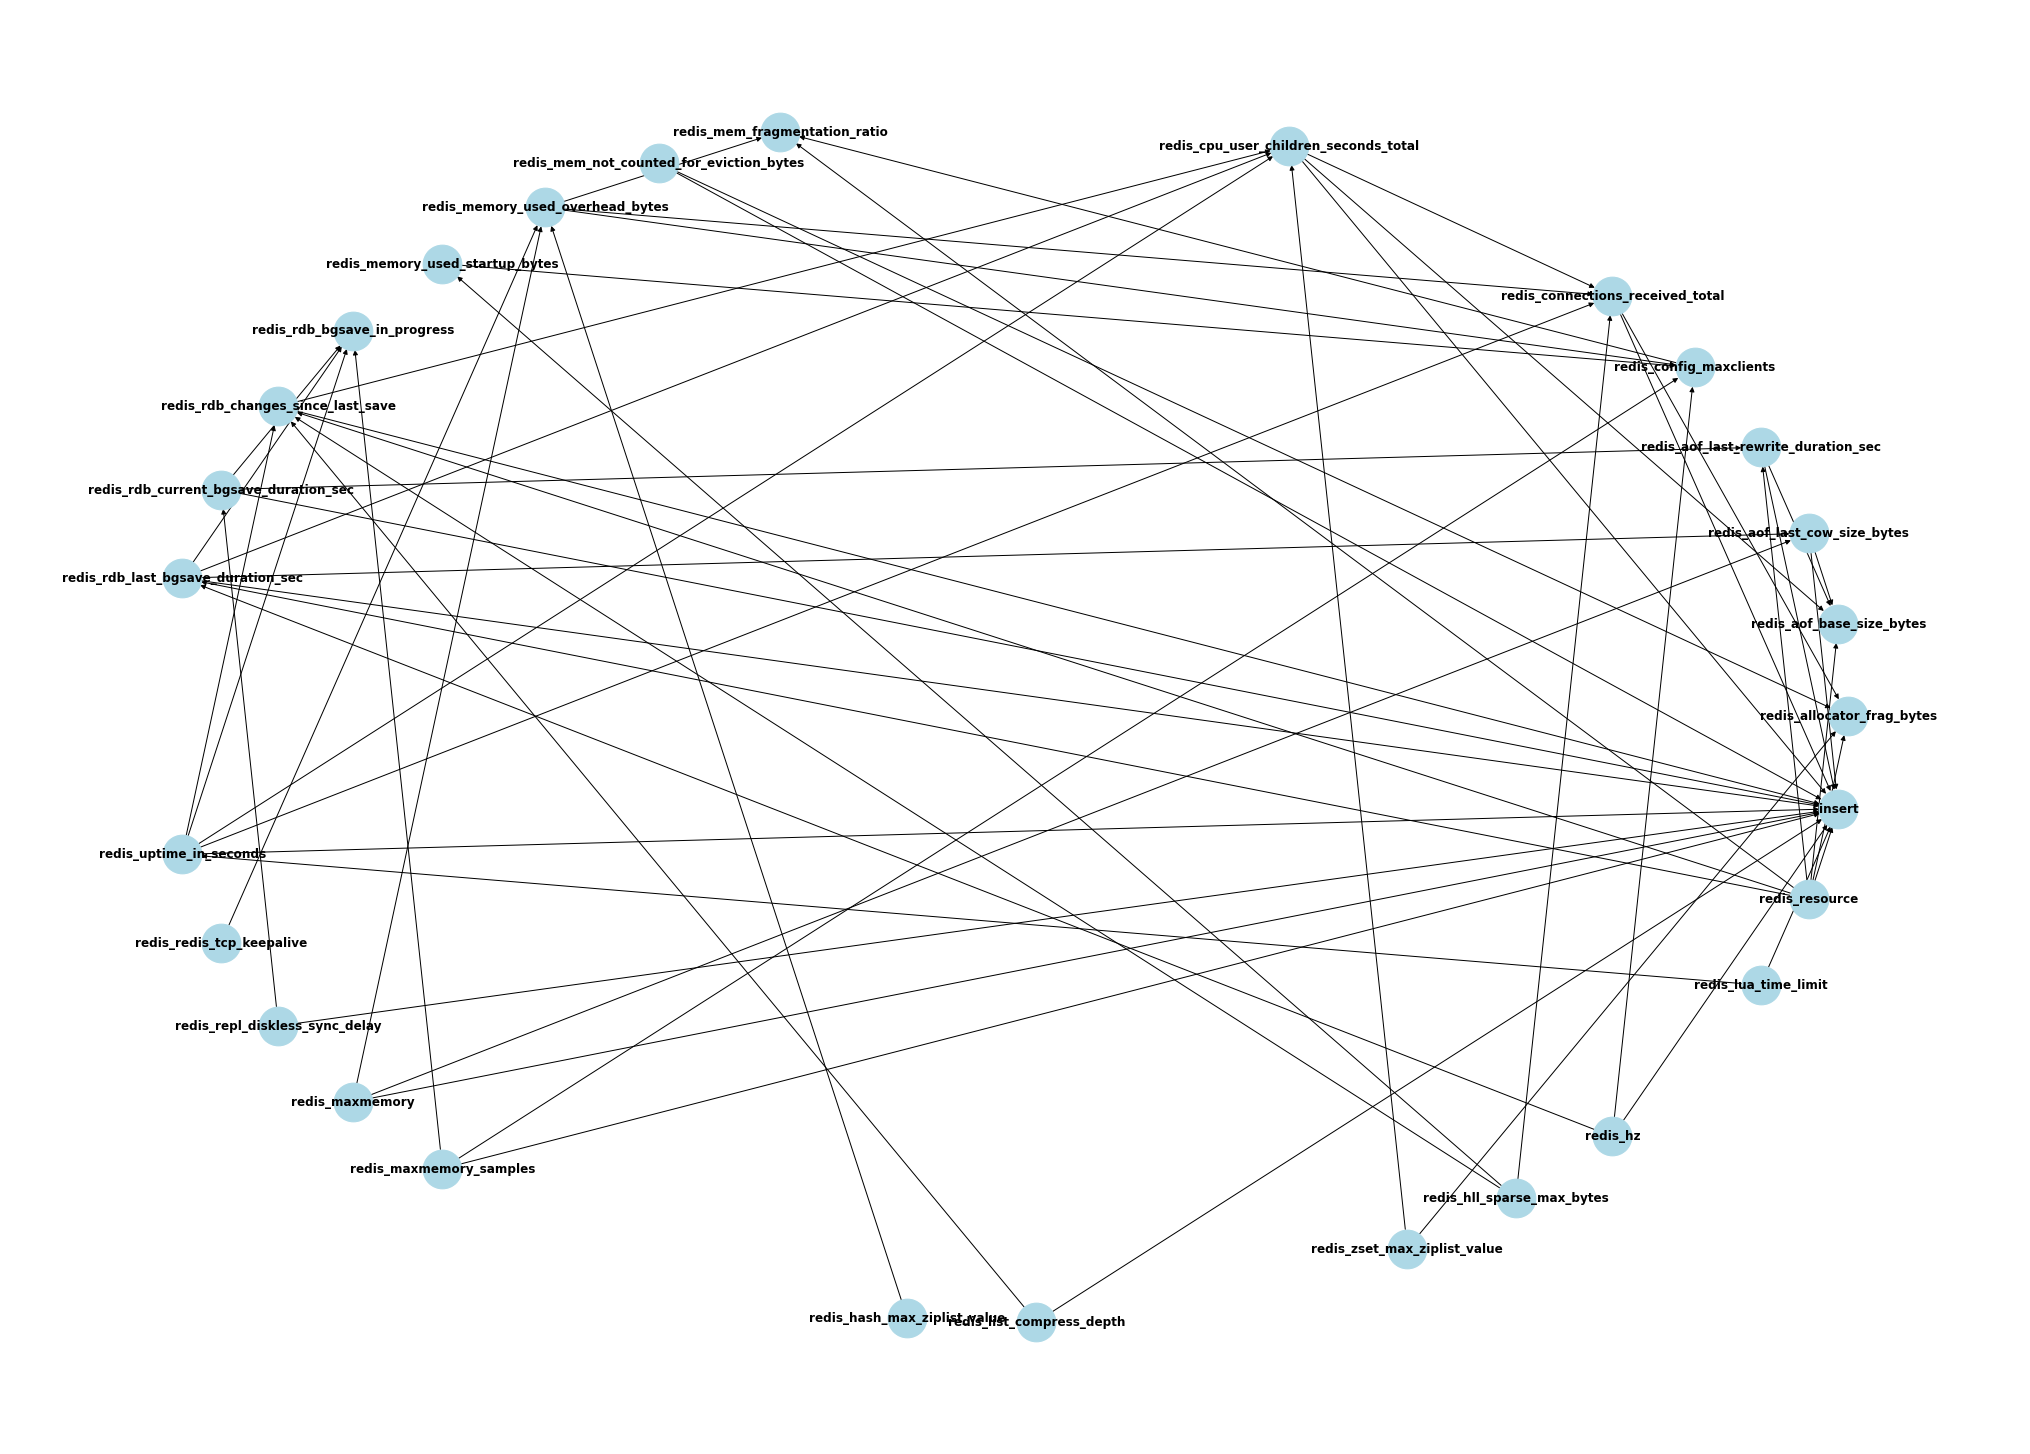

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
g = DiGraph()
g.add_nodes_from(columns)
g.add_edges_from(di_edges + bi_edges)
plt.figure(figsize=(28, 20))
pos_circular = nx.circular_layout(g)
isolated_nodes = [node for node in g.nodes() if g.degree(node) == 0]

g.remove_nodes_from(isolated_nodes)
nx.draw(g, pos=pos_circular,with_labels=True, node_color='lightblue', node_size=1500, font_weight='bold')
plt.show()

In [20]:
paths = CM.get_causal_paths(columns, di_edges ,bi_edges,obj_columns)
paths

{'insert': [['insert', 'redis_resource'],
  ['insert', 'redis_hz'],
  ['insert', 'redis_resource'],
  ['insert', 'redis_mem_not_counted_for_eviction_bytes'],
  ['insert', 'redis_maxmemory'],
  ['insert', 'redis_resource'],
  ['insert', 'redis_hz'],
  ['insert', 'redis_lua_time_limit'],
  ['insert', 'redis_maxmemory_samples'],
  ['insert', 'redis_uptime_in_seconds', 'redis_lua_time_limit'],
  ['insert', 'redis_uptime_in_seconds', 'redis_lua_time_limit'],
  ['insert', 'redis_maxmemory'],
  ['insert', 'redis_aof_last_rewrite_duration_sec', 'redis_resource'],
  ['insert',
   'redis_aof_last_rewrite_duration_sec',
   'redis_rdb_current_bgsave_duration_sec',
   'redis_repl_diskless_sync_delay'],
  ['insert', 'redis_aof_last_cow_size_bytes', 'redis_maxmemory'],
  ['insert',
   'redis_aof_last_cow_size_bytes',
   'redis_rdb_last_bgsave_duration_sec',
   'redis_hz'],
  ['insert',
   'redis_aof_last_cow_size_bytes',
   'redis_rdb_last_bgsave_duration_sec',
   'redis_resource'],
  ['insert', 'red

In [21]:
from ananke.estimation import CausalEffect as CE

def compute_path_causal_effect(df, paths,
                               G, K):
    """This function is used to compute P_ACE for each path"""
    ace = {}
    strategy = {'a-fixable':'aipw',
                'p-fixable':'apipw',
                'nested-fixable':'n-ipw'}
    for items in paths:
        for path in paths.get(items):
            ace[str(path)] = 0
            for i in range(0, len(path)):
                if i > 0:
                    obj = CE(graph=G, treatment=path[i], outcome=path[0])  # 使用ananke估计平均因果效应
                    ace[str(path)] += obj.compute_effect(df, 'gformula')
    paths_dict = {k: v for k, v in sorted(ace.items(), key=lambda item: item[1], reverse=True)}
    if K == 0 :
        paths = list(paths_dict.keys())
    else:
        paths = list(paths_dict.keys())[:K]
    return paths

In [22]:
from ananke.estimation import CausalEffect as CE

def compute_path_causal_effect(df, paths,
                               G, K):
    """This function is used to compute P_ACE for each path"""
    ace = {}
    strategy = {'a-fixable':'aipw',
                'p-fixable':'apipw',
                'nested-fixable':'n-ipw'}
    for items in paths:
        for path in paths.get(items):
            ace[str(path)] = 0
            for i in range(0, len(path)):
                if i > 0:
                    obj = CE(graph=G, treatment=path[i], outcome=path[0])  # 使用ananke估计平均因果效应
                    ace[str(path)] += obj.compute_effect(df, 'gformula')
    paths_dict = {k: v for k, v in sorted(ace.items(), key=lambda item: item[1], reverse=True)}
    if K == 0 :
        paths = list(paths_dict.keys())
    else:
        paths = list(paths_dict.keys())[:K]
    # paths = [eval(key) for key in paths]
    return paths

In [23]:

key_paths = compute_path_causal_effect(df,paths,G,0)


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIP

In [24]:
key_paths

["['insert', 'redis_aof_last_rewrite_duration_sec', 'redis_rdb_current_bgsave_duration_sec', 'redis_repl_diskless_sync_delay']",
 "['insert', 'redis_rdb_last_bgsave_duration_sec', 'redis_hz']",
 "['insert', 'redis_aof_last_cow_size_bytes', 'redis_rdb_last_bgsave_duration_sec', 'redis_hz']",
 "['insert', 'redis_rdb_last_bgsave_duration_sec', 'redis_resource']",
 "['insert', 'redis_aof_last_cow_size_bytes', 'redis_rdb_last_bgsave_duration_sec', 'redis_resource']",
 "['insert', 'redis_aof_last_rewrite_duration_sec', 'redis_resource']",
 "['insert', 'redis_connections_received_total', 'redis_cpu_user_children_seconds_total', 'redis_rdb_last_bgsave_duration_sec', 'redis_hz']",
 "['insert', 'redis_cpu_user_children_seconds_total', 'redis_rdb_last_bgsave_duration_sec', 'redis_hz']",
 "['insert', 'redis_rdb_current_bgsave_duration_sec', 'redis_repl_diskless_sync_delay']",
 "['insert', 'redis_connections_received_total', 'redis_cpu_user_children_seconds_total', 'redis_rdb_last_bgsave_duration_s

In [25]:
key_para = {}
for path in key_paths:

    p = path.split(', ')[-1].split(']')[0].split("'")[1]
    if p not in conf_opt:
        continue
    if p in key_para:
        key_para[p] += 1
    else:
        key_para[p] = 1
key_para


{'redis_repl_diskless_sync_delay': 3,
 'redis_hz': 5,
 'redis_resource': 9,
 'redis_lua_time_limit': 8,
 'redis_hll_sparse_max_bytes': 4,
 'redis_list_compress_depth': 4,
 'redis_maxmemory_samples': 1,
 'redis_maxmemory': 3,
 'redis_redis_tcp_keepalive': 1,
 'redis_hash_max_ziplist_value': 1,
 'redis_zset_max_ziplist_value': 2}